# A Deep Dive into the HDB Resale Prices Dataset #

#### Import necessary libraries ####

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score

from sklearn.cluster import KMeans
import matplotlib.ticker as ticker

from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import warnings
from sklearn.exceptions import ConvergenceWarning

## Some ConvergenceWarning with ElasticNet but after checking with increased max_iter, the values do not change much
warnings.filterwarnings("ignore", category=ConvergenceWarning)

##### The dataset is imported using pandas #####

In [2]:
data= pd.read_csv(r"Resale flat prices based on registration date from Jan-2017 onwards.csv")
data

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0
...,...,...,...,...,...,...,...,...,...,...,...
191662,2024-10,YISHUN,5 ROOM,504C,YISHUN ST 51,10 TO 12,113.0,Improved,2016,90 years 06 months,747000.0
191663,2024-10,YISHUN,5 ROOM,502D,YISHUN ST 51,04 TO 06,112.0,Improved,2018,92 years 04 months,725000.0
191664,2024-10,YISHUN,5 ROOM,644,YISHUN ST 61,07 TO 09,123.0,Improved,1988,62 years 09 months,728000.0
191665,2024-10,YISHUN,5 ROOM,870,YISHUN ST 81,04 TO 06,122.0,Improved,1987,62 years 04 months,690000.0


In [3]:
print(data.dtypes)

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
remaining_lease         object
resale_price           float64
dtype: object


In [4]:
data['extracted_month'] = data['month'].apply(lambda x: int(x.split('-')[1]))

In [5]:
data['extracted_month']

0          1
1          1
2          1
3          1
4          1
          ..
191662    10
191663    10
191664    10
191665    10
191666    10
Name: extracted_month, Length: 191667, dtype: int64

In [6]:
data['month'].info
data['month'] = pd.to_datetime(data['month'], format='%Y-%m')

In [7]:

data['month'].info

<bound method Series.info of 0        2017-01-01
1        2017-01-01
2        2017-01-01
3        2017-01-01
4        2017-01-01
            ...    
191662   2024-10-01
191663   2024-10-01
191664   2024-10-01
191665   2024-10-01
191666   2024-10-01
Name: month, Length: 191667, dtype: datetime64[ns]>

In [8]:
data['street_name'].unique()

array(['ANG MO KIO AVE 10', 'ANG MO KIO AVE 4', 'ANG MO KIO AVE 5',
       'ANG MO KIO AVE 1', 'ANG MO KIO AVE 3', 'ANG MO KIO AVE 9',
       'ANG MO KIO AVE 8', 'ANG MO KIO AVE 6', 'ANG MO KIO ST 52',
       'BEDOK NTH AVE 4', 'BEDOK NTH AVE 1', 'BEDOK NTH RD',
       'BEDOK STH AVE 1', 'BEDOK RESERVOIR RD', 'CHAI CHEE ST',
       'BEDOK NTH ST 3', 'BEDOK STH RD', 'CHAI CHEE AVE',
       'NEW UPP CHANGI RD', 'CHAI CHEE DR', 'BEDOK STH AVE 2',
       'BEDOK NTH AVE 3', 'BEDOK RESERVOIR VIEW', 'CHAI CHEE RD',
       'LENGKONG TIGA', 'BEDOK CTRL', 'JLN DAMAI', 'BEDOK NTH AVE 2',
       'BEDOK STH AVE 3', 'SIN MING RD', 'SIN MING AVE', 'BISHAN ST 12',
       'BISHAN ST 13', 'BISHAN ST 22', 'BISHAN ST 24', 'BISHAN ST 23',
       'BRIGHT HILL DR', 'SHUNFU RD', 'BT BATOK ST 34', 'BT BATOK ST 51',
       'BT BATOK ST 11', 'BT BATOK ST 52', 'BT BATOK ST 21',
       'BT BATOK EAST AVE 5', 'BT BATOK WEST AVE 6', 'BT BATOK CTRL',
       'BT BATOK WEST AVE 8', 'BT BATOK EAST AVE 4', 'BT BATOK ST 3

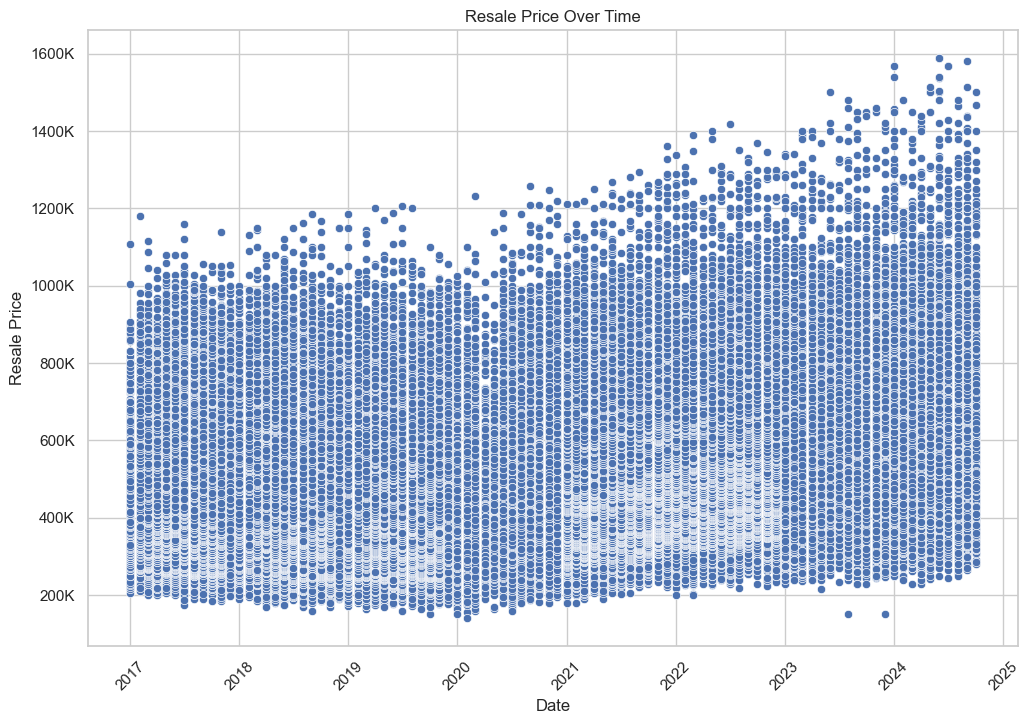

In [9]:
sns.set(style='whitegrid')

# Create the seaborn scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='month', y='resale_price', data=data)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Resale Price')
plt.title('Resale Price Over Time')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1000)}K'))

# Show the plot
plt.show()

Exploratory Data Analysis

In [10]:
data['flat_type'].value_counts(),data['flat_type'].info

(flat_type
 4 ROOM              80911
 5 ROOM              47507
 3 ROOM              45442
 EXECUTIVE           14134
 2 ROOM               3523
 MULTI-GENERATION       79
 1 ROOM                 71
 Name: count, dtype: int64,
 <bound method Series.info of 0            2 ROOM
 1            3 ROOM
 2            3 ROOM
 3            3 ROOM
 4            3 ROOM
             ...    
 191662       5 ROOM
 191663       5 ROOM
 191664       5 ROOM
 191665       5 ROOM
 191666    EXECUTIVE
 Name: flat_type, Length: 191667, dtype: object>)

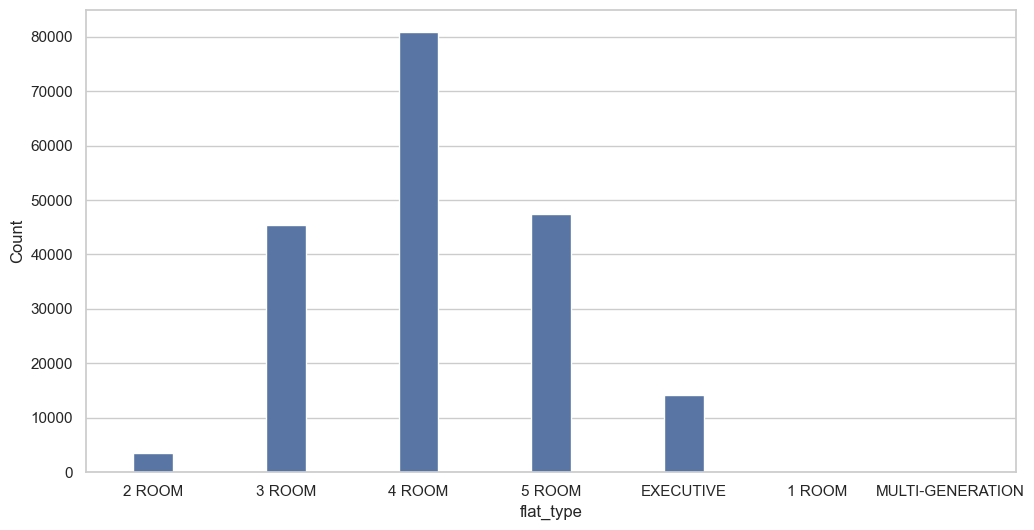

In [11]:
plt.figure(figsize=(12, 6))
sns.countplot(x='flat_type', data=data, width=0.3)
# Add labels and title
plt.xlabel('flat_type')
plt.ylabel('Count')

# Show the plot
plt.show()

Clean Flat Type, Ordinally Encode it

In [12]:
flat_type_order = ['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']
# Create a mapping from flat types to integers
flat_type_mapping = {flat_type: idx +1 for idx, flat_type in enumerate(flat_type_order)}

# Apply the mapping to create a new encoded column
data['flat_type_encoded'] = data['flat_type'].map(flat_type_mapping)


In [13]:
data['storey_range'].value_counts(),data['storey_range'].info

(storey_range
 04 TO 06    44062
 07 TO 09    40213
 10 TO 12    35716
 01 TO 03    33860
 13 TO 15    18385
 16 TO 18     8639
 19 TO 21     3718
 22 TO 24     2619
 25 TO 27     1596
 28 TO 30     1039
 31 TO 33      562
 34 TO 36      510
 37 TO 39      426
 40 TO 42      203
 43 TO 45       58
 46 TO 48       45
 49 TO 51       16
 Name: count, dtype: int64,
 <bound method Series.info of 0         10 TO 12
 1         01 TO 03
 2         01 TO 03
 3         04 TO 06
 4         01 TO 03
             ...   
 191662    10 TO 12
 191663    04 TO 06
 191664    07 TO 09
 191665    04 TO 06
 191666    10 TO 12
 Name: storey_range, Length: 191667, dtype: object>)

In [14]:
# One-hot encode the 'storey_range' column and join it back to the original DataFrame
data = pd.concat([data, pd.get_dummies(data['storey_range'], prefix='storey_range')], axis=1)

In [15]:
data['town'].value_counts(),data['town'].info

# One-hot encode the 'town' column and join it back to the original DataFrame
data = pd.concat([data, pd.get_dummies(data['town'], prefix='town')], axis=1)

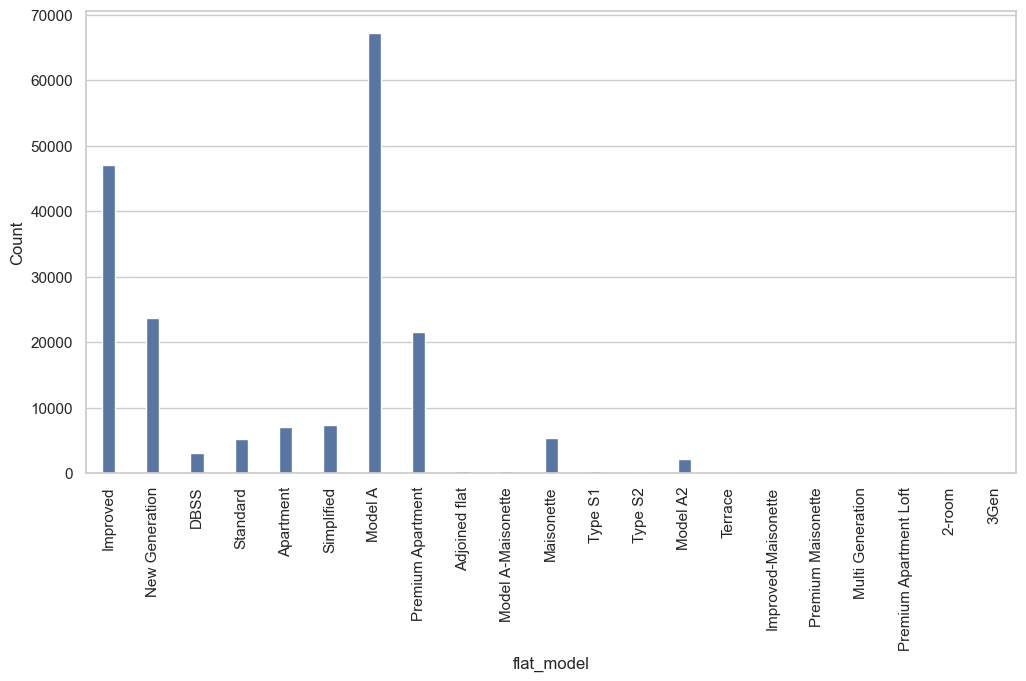

In [16]:
plt.figure(figsize=(12, 6))
sns.countplot(x='flat_model', data=data, width=0.3)
# Add labels and title
plt.xlabel('flat_model')
plt.xticks(rotation=90)
plt.ylabel('Count')

# Show the plot
plt.show()

In [17]:
data['flat_model'].value_counts(),data['flat_model'].info

# One-hot encode the 'town' column and join it back to the original DataFrame
data = pd.concat([data, pd.get_dummies(data['flat_model'], prefix='town')], axis=1)

In [18]:
data

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,town_Multi Generation,town_New Generation,town_Premium Apartment,town_Premium Apartment Loft,town_Premium Maisonette,town_Simplified,town_Standard,town_Terrace,town_Type S1,town_Type S2
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,...,False,False,False,False,False,False,False,False,False,False
1,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,...,False,True,False,False,False,False,False,False,False,False
2,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,...,False,True,False,False,False,False,False,False,False,False
3,2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,...,False,True,False,False,False,False,False,False,False,False
4,2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191662,2024-10-01,YISHUN,5 ROOM,504C,YISHUN ST 51,10 TO 12,113.0,Improved,2016,90 years 06 months,...,False,False,False,False,False,False,False,False,False,False
191663,2024-10-01,YISHUN,5 ROOM,502D,YISHUN ST 51,04 TO 06,112.0,Improved,2018,92 years 04 months,...,False,False,False,False,False,False,False,False,False,False
191664,2024-10-01,YISHUN,5 ROOM,644,YISHUN ST 61,07 TO 09,123.0,Improved,1988,62 years 09 months,...,False,False,False,False,False,False,False,False,False,False
191665,2024-10-01,YISHUN,5 ROOM,870,YISHUN ST 81,04 TO 06,122.0,Improved,1987,62 years 04 months,...,False,False,False,False,False,False,False,False,False,False


In [19]:
memory_usage = data.memory_usage(deep=True).sum()/(1024**2)
print (f"Memory Usage of DataFrame: {memory_usage:.2f} MB")

Memory Usage of DataFrame: 95.40 MB


In [20]:
data['age']=2024-data['lease_commence_date']

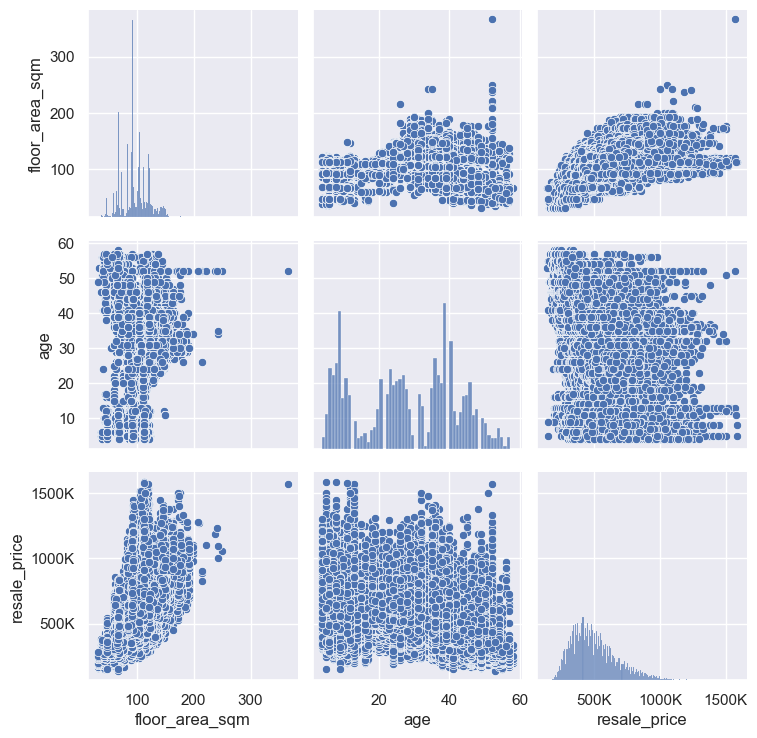

In [21]:
sns.set_theme(style="darkgrid")

numeric_cols = data[['floor_area_sqm', 
                    #  'lease_commence_date', 
                     'age', 
                     'resale_price']]
g=sns.pairplot(numeric_cols)
for ax in g.axes.flat:
    if ax.get_xlabel() == 'resale_price':
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x / 1000)}K'))
    if ax.get_ylabel() == 'resale_price':
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y / 1000)}K'))
plt.show()

#### Plot the categorical data ####

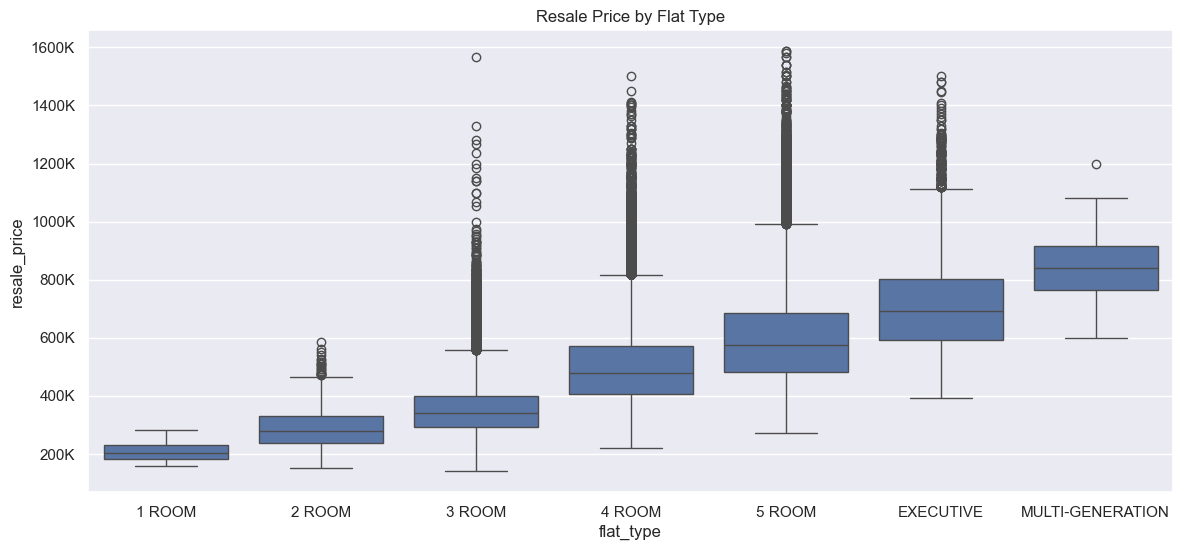

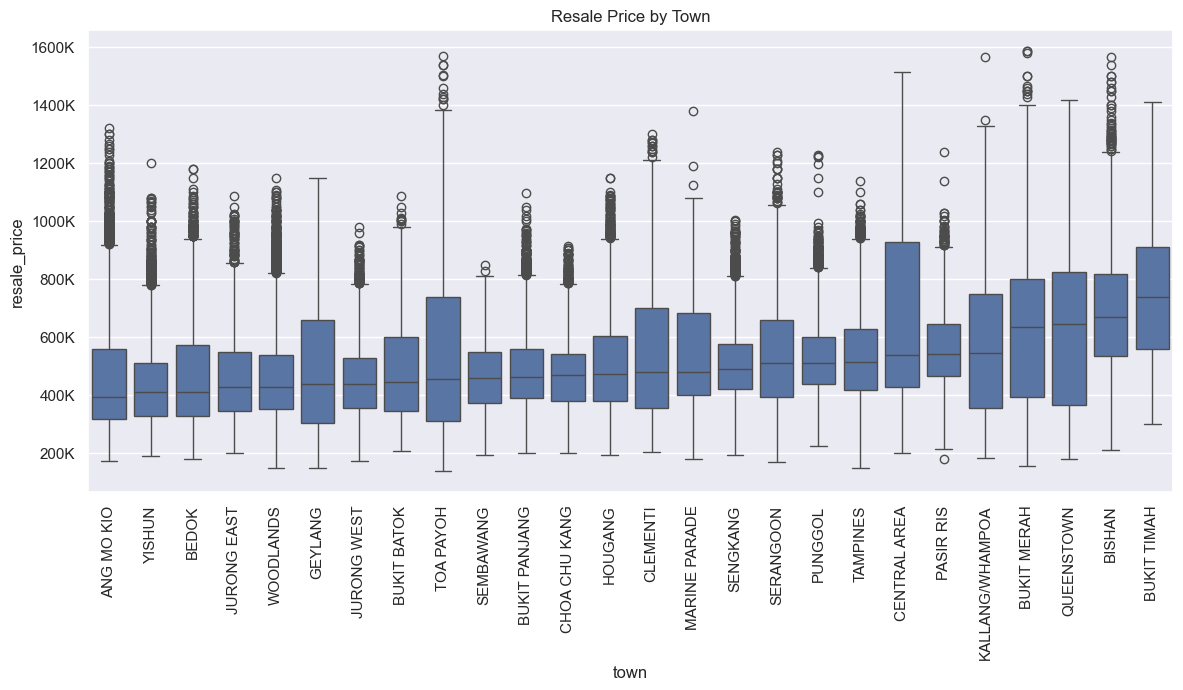

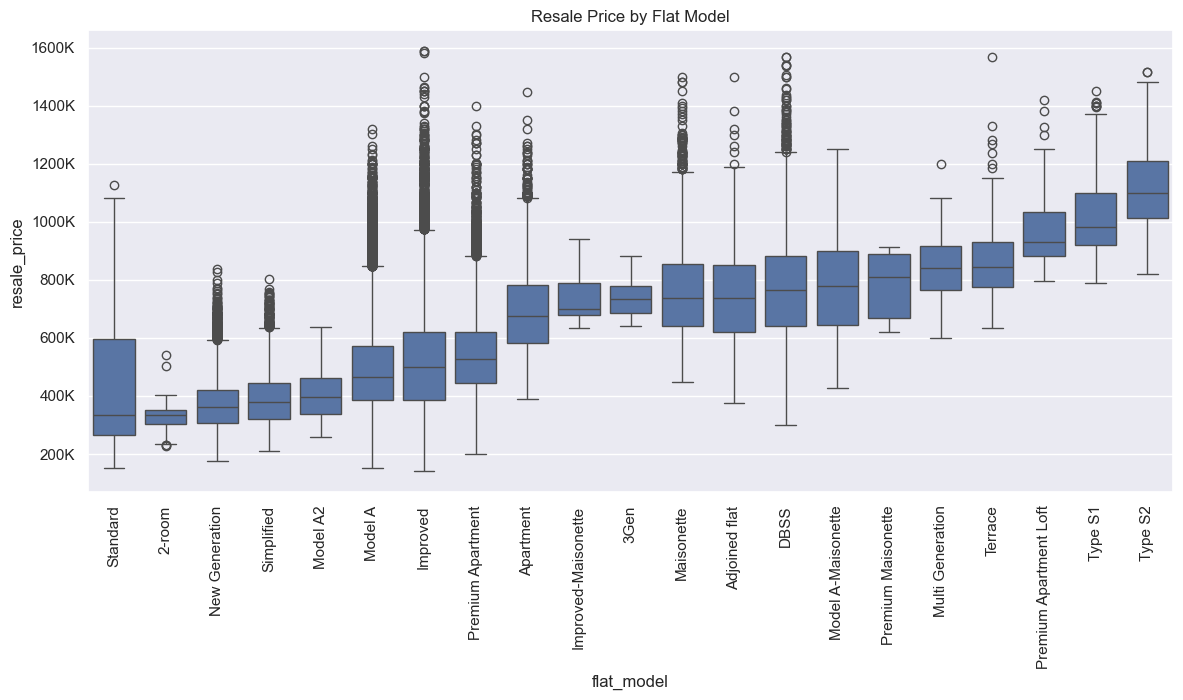

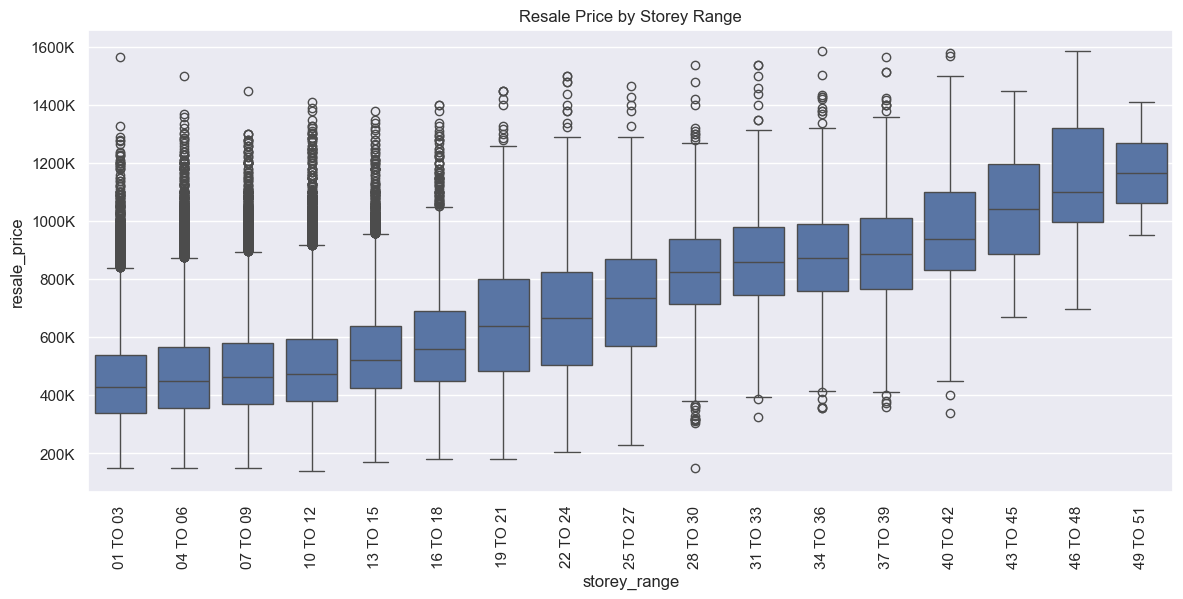

In [22]:
flat_type_median_resale_price = data.groupby('flat_type')['resale_price'].median().sort_values()
order = flat_type_median_resale_price.index

plt.figure(figsize=(14, 6))
sns.boxplot(data=data, x='flat_type', y='resale_price', order=order)
plt.title("Resale Price by Flat Type")
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1000)}K'))
plt.show()

# Calculate the median resale price for each town and sort in ascending order
town_median_resale_price = data.groupby('town')['resale_price'].median().sort_values()

# Ensure the order matches the unique values in the 'town' column
order = town_median_resale_price.index.intersection(data['town'].unique())

plt.figure(figsize=(14, 6))
sns.boxplot(data=data, x='town', y='resale_price', order = order)
plt.title("Resale Price by Town")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1000)}K'))
plt.show()

# Calculate the median resale price for each flat model and sort in ascending order
flat_model_median_resale_price = data.groupby('flat_model')['resale_price'].median().sort_values()

# Ensure the order matches the unique values in the 'flat_model' column
order = flat_model_median_resale_price.index.intersection(data['flat_model'].unique())

plt.figure(figsize=(14, 6))
sns.boxplot(data=data, x='flat_model', y='resale_price', order = order)
plt.title("Resale Price by Flat Model")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1000)}K'))
plt.show()




# We will Order the storey_range column in ascending order.
order = ['01 TO 03', '04 TO 06', '07 TO 09', '10 TO 12', '13 TO 15', 
 '16 TO 18', '19 TO 21', '22 TO 24', '25 TO 27', '28 TO 30', 
 '31 TO 33', '34 TO 36', '37 TO 39', '40 TO 42', '43 TO 45', 
 '46 TO 48', '49 TO 51']

plt.figure(figsize=(14, 6))
sns.boxplot(data=data, x='storey_range', y='resale_price', order = order)
plt.title("Resale Price by Storey Range")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1000)}K'))
plt.show()

# Methodology #

In [23]:
data

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,town_New Generation,town_Premium Apartment,town_Premium Apartment Loft,town_Premium Maisonette,town_Simplified,town_Standard,town_Terrace,town_Type S1,town_Type S2,age
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,...,False,False,False,False,False,False,False,False,False,45
1,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,...,True,False,False,False,False,False,False,False,False,46
2,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,...,True,False,False,False,False,False,False,False,False,44
3,2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,...,True,False,False,False,False,False,False,False,False,44
4,2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,...,True,False,False,False,False,False,False,False,False,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191662,2024-10-01,YISHUN,5 ROOM,504C,YISHUN ST 51,10 TO 12,113.0,Improved,2016,90 years 06 months,...,False,False,False,False,False,False,False,False,False,8
191663,2024-10-01,YISHUN,5 ROOM,502D,YISHUN ST 51,04 TO 06,112.0,Improved,2018,92 years 04 months,...,False,False,False,False,False,False,False,False,False,6
191664,2024-10-01,YISHUN,5 ROOM,644,YISHUN ST 61,07 TO 09,123.0,Improved,1988,62 years 09 months,...,False,False,False,False,False,False,False,False,False,36
191665,2024-10-01,YISHUN,5 ROOM,870,YISHUN ST 81,04 TO 06,122.0,Improved,1987,62 years 04 months,...,False,False,False,False,False,False,False,False,False,37


In [24]:
# Sample from 10% of data as dataset is too large to fit into memory.

data=data.sample(frac=0.1, random_state=42)

# data = data.groupby('age_group', group_keys=False).apply(lambda x: x.sample(frac=0.15, random_state=42))

# Drop features that were not cleaned
data.drop(columns=['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model', 'remaining_lease'], errors='ignore', inplace=True)
# data.drop(columns=['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model', 'remaining_lease', 'age_group'], errors='ignore', inplace=True)

#### 3 Methods of Supervised Learning are attempted - ElasticNet, Polynomial Kernel and RBF Kernel ####

#### Elastic Net ####

Elastic Net is a regularized regression method that combines both L1 (Lasso) and L2 (Ridge) penalties to create a more flexible model, useful when dealing with datasets that have multicollinearity or when feature selection is needed. When coupled with a polynomial fit of degree 2, Elastic Net can capture non-linear relationships between features while maintaining control over model complexity.

The Elastic Net loss function is defined as:

$$
L_{\text{Elastic Net}} = \frac{1}{2n} \| y - Xw \|_2^2 + \alpha \cdot \lambda_1 \cdot \| w \|_1 + \frac{1}{2} \cdot \alpha \cdot (1 - \lambda_1) \cdot \| w \|_2^2
$$

where:
- $n$ is the number of samples,
- $y$ is the vector of observed values,
- $X$ is the matrix of input features,
- $w$ is the vector of model coefficients,
- $\alpha$ is the overall regularization parameter,
- $\lambda_1$ controls the balance between L1 (Lasso) and L2 (Ridge) penalties.

The Elastic Net combines both L1 and L2 regularization terms, allowing it to handle datasets with multicollinearity and perform variable selection.

#### Polynomial Kernel ####

In this study, kernel methods were preferred due to the high-dimensionality of the dataset. Kernel methods avoid the high complexity of high-dimensionality data by using the kernel trick.

The polynomial kernel is used as it is able to capture non-linear relationships.

$K(x_i, x_j) = (\gamma x_i^T x_j + r)^d$

where:
- $\gamma$ is a free parameter that scales the dot product $x_i^T x_j$,
- $r$ is a constant term that controls the offset,
- $d$ is the degree of the polynomial, determining the flexibility of the kernel.

The polynomial kernel represents the similarity between vectors $x_i$ and $x_j$ as a polynomial function of their dot product.

#### RBF Kernel ####

Addtionally, let's look into the RBF kernel. As RBF kernal is sensitive to relative magnitude of the features since it uses Euclidean distance.

RBF Kernel is defined by:

$K(x_i, x_j) = \exp\left(-\gamma \|x_i - x_j\|^2\right)$

where:
- $x_i$ and $x_j$ are feature vectors,
- $\gamma$ is a free parameter that controls the spread of the kernel and thus the influence of each training example.

The RBF kernel measures similarity based on the distance between feature vectors $x_i$ and $x_j$, with closer vectors having a higher similarity score.

In [25]:
# Features and target variable
X = data.drop(columns=['resale_price'])
y = data['resale_price']


 #### Write a function to be reused to train the 3 supervised learning models, ElasticNet (with polynomial fit), Polynomial Kernel, and RBF Kernel ####

 A 3-fold cross validation is used in this study to evaluate the models. For models with parameters that can be tuned, GridSearchCV is used to find the optimal parameters 

In [26]:
def train_models(x_input,pca_flag):
    if not pca_flag:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(x_input)
        # Create polynomial features to use for Elastic Net
        poly = PolynomialFeatures(degree=2, include_bias=False)
        X_poly = poly.fit_transform(X_scaled)
    else:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(x_input)
        
        ## Perform PCA on dataset if PCA_flag is enabled, now X_scaled becomes PCA
        pca = PCA(n_components=20)
        X_scaled=pca.fit_transform(X_scaled)

        # Create polynomial features to use for Elastic Net
        poly = PolynomialFeatures(degree=2, include_bias=False)
        X_poly = poly.fit_transform(X_scaled)
        
    # Initialize KRR models, ElasticNet, and Polynomial Model
    models = {
        'elastic_net': ElasticNet(),
        'polynomial_kernel': KernelRidge(kernel='poly', degree=2),
        'rbf_kernel': KernelRidge(kernel='rbf'),
    }

    # Set up cross-validation with 3 folds
    cv = KFold(n_splits=3, shuffle=True, random_state=42)

    # Define parameter grids for ElasticNet and RBF KernelRidge
    param_grids = {
        'elastic_net': {
            'alpha': [0.1, 1.0, 10.0],
            'l1_ratio': [0.1, 0.5, 0.9],
        },
        'rbf_kernel': {
            'alpha': [0.01, 0.1, 1.0],
            'gamma': [0.01, 0.1, 1.0],
        }
    }

    # Prepare for subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))  # Adjusted for two rows of 2 columns each
    axes = axes.flatten()

    # Iterate over models and perform cross-validation
    count = 0
    for model_name, model in models.items():
        # Select the feature set for each model
        if model_name in ['elastic_net']:
            X_to_use = X_poly  # Use polynomial features for ElasticNet
        else:
            X_to_use = X_scaled  # Use original features for KernelRidge models
        
        if model_name in param_grids:
            # Perform grid search for ElasticNet and RBF KernelRidge
            grid_search = GridSearchCV(model, param_grids[model_name], cv=cv, scoring='r2')
            grid_search.fit(X_to_use, y)
            best_model = grid_search.best_estimator_
            scores = cross_val_score(best_model, X_to_use, y, cv=cv, scoring='r2')
            
            # Fit the best model on the full dataset and predict
            best_model.fit(X_to_use, y)
            y_pred = best_model.predict(X_to_use)
            
            # Print the best parameters
            print(f"Model: {model_name} (Grid Search)")
            print(f"Best Parameters: {grid_search.best_params_}")
        else:
            # Perform regular cross-validation for Polynomial and Polynomial Kernel models
            scores = cross_val_score(model, X_to_use, y, cv=cv, scoring='r2')
            
            # Fit the model on the full dataset and predict
            model.fit(X_to_use, y)
            y_pred = model.predict(X_to_use)
            
            print(f"Model: {model_name} (Regular CV)")
        
        # Plot the true vs predicted resale prices
        sns.scatterplot(x=y, y=y_pred, ax=axes[count])
        min_value = min(axes[count].get_xlim()[0], axes[count].get_ylim()[0])
        max_value = max(axes[count].get_xlim()[1], axes[count].get_ylim()[1])
        axes[count].plot([min_value, max_value], [min_value, max_value], color='black', linestyle=':', label='Perfect Prediction')
        axes[count].legend()
        axes[count].set_title(f'{model_name} - True vs Predicted')
        axes[count].set_xlabel("Resale Price (True)")
        axes[count].set_ylabel("Resale Price (Predicted)")

        # Print cross-validation and evaluation metrics
        print(f"Cross-validated R² scores: {scores}")
        print(f"Mean R² score (cross-val): {np.mean(scores):.4f}")
        print(f"Standard deviation (cross-val): {np.std(scores):.4f}")
        print("\n")

        count += 1

    # Set a big title for the entire plot
    fig.suptitle("Comparison of Model Performance", fontsize=20, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
    plt.show()

Model: elastic_net (Grid Search)
Best Parameters: {'alpha': 0.1, 'l1_ratio': 0.9}
Cross-validated R² scores: [0.79827203 0.80346502 0.79285006]
Mean R² score (cross-val): 0.7982
Standard deviation (cross-val): 0.0043


Model: polynomial_kernel (Regular CV)
Cross-validated R² scores: [0.80120618 0.80621991 0.7970556 ]
Mean R² score (cross-val): 0.8015
Standard deviation (cross-val): 0.0037


Model: rbf_kernel (Grid Search)
Best Parameters: {'alpha': 0.1, 'gamma': 0.01}
Cross-validated R² scores: [0.75258613 0.77568792 0.77311702]
Mean R² score (cross-val): 0.7671
Standard deviation (cross-val): 0.0103




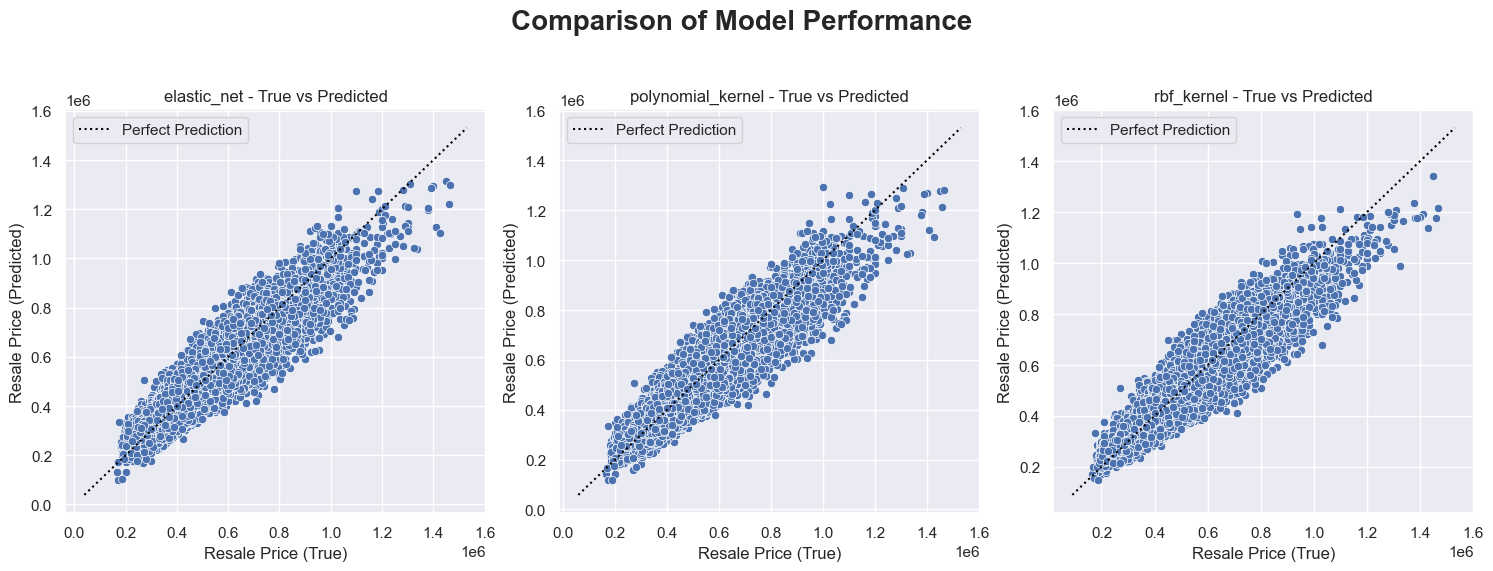

In [27]:
train_models(X,pca_flag=False)

##### Using a polynomial feature of >2 results in extremely long runtimes due to suffering from the curse of dimensionality. KRR handles non-linear relationships more easily by projecting the data into higher dimensions without the need to explicitly calculate the features  #####

#### Principal Component Analysis (PCA) - Unsupervised Learning Method 1 ###

In the search to improve the model results, PCA is a dimensionality reduction method used to transform a set of correlated variables into a smaller number of uncorrelated variables called principal components. Due to the high-dimensionality of the dataset which may have excessive noise, and many features that result in long compute times, PCA is used to see if there is a noticeable improvement in the Mean R² score and while lowering the compute times.

Here are the PCA steps:

Given a dataset $X$ with $n$ observations and $p$ features, represented as a matrix:

1. **Center the Data**: Subtract the mean of each feature from the dataset, resulting in a mean-centered matrix $X$.

2. **Compute the Covariance Matrix**:
   $$
   \Sigma = \frac{1}{n-1} X^T X
   $$
   where $\Sigma$ is a $p \times p$ covariance matrix representing the variance and covariance between features.

3. **Calculate Eigenvalues and Eigenvectors**:
   Find the eigenvalues $\lambda_i$ and eigenvectors $v_i$ of the covariance matrix $\Sigma$ by solving:
   $$
   \Sigma v_i = \lambda_i v_i
   $$
   The eigenvectors represent the directions of maximum variance, while the eigenvalues indicate the magnitude of variance in each direction.

4. **Select Principal Components**:
   Choose the top $k$ eigenvectors (those with the largest eigenvalues) to form a new feature space, reducing the dataset from $p$ dimensions to $k$ dimensions.

5. **Transform the Data**:
   Project the original dataset $X$ onto the new feature space defined by the top $k$ eigenvectors:
   $$
   Z = X W
   $$
   where $W$ is the matrix of selected eigenvectors, and $Z$ is the transformed data in the reduced $k$-dimensional space.

In summary, PCA identifies the directions of maximum variance in the data and projects it onto a lower-dimensional space, preserving as much variance as possible with each principal component orthogonal to the others.

Model: elastic_net (Grid Search)
Best Parameters: {'alpha': 0.1, 'l1_ratio': 0.5}
Cross-validated R² scores: [0.6819436  0.67815187 0.69121565]
Mean R² score (cross-val): 0.6838
Standard deviation (cross-val): 0.0055


Model: polynomial_kernel (Regular CV)
Cross-validated R² scores: [0.66970698 0.65298868 0.69226381]
Mean R² score (cross-val): 0.6717
Standard deviation (cross-val): 0.0161


Model: rbf_kernel (Grid Search)
Best Parameters: {'alpha': 0.01, 'gamma': 0.01}
Cross-validated R² scores: [0.77580105 0.77651951 0.77783384]
Mean R² score (cross-val): 0.7767
Standard deviation (cross-val): 0.0008




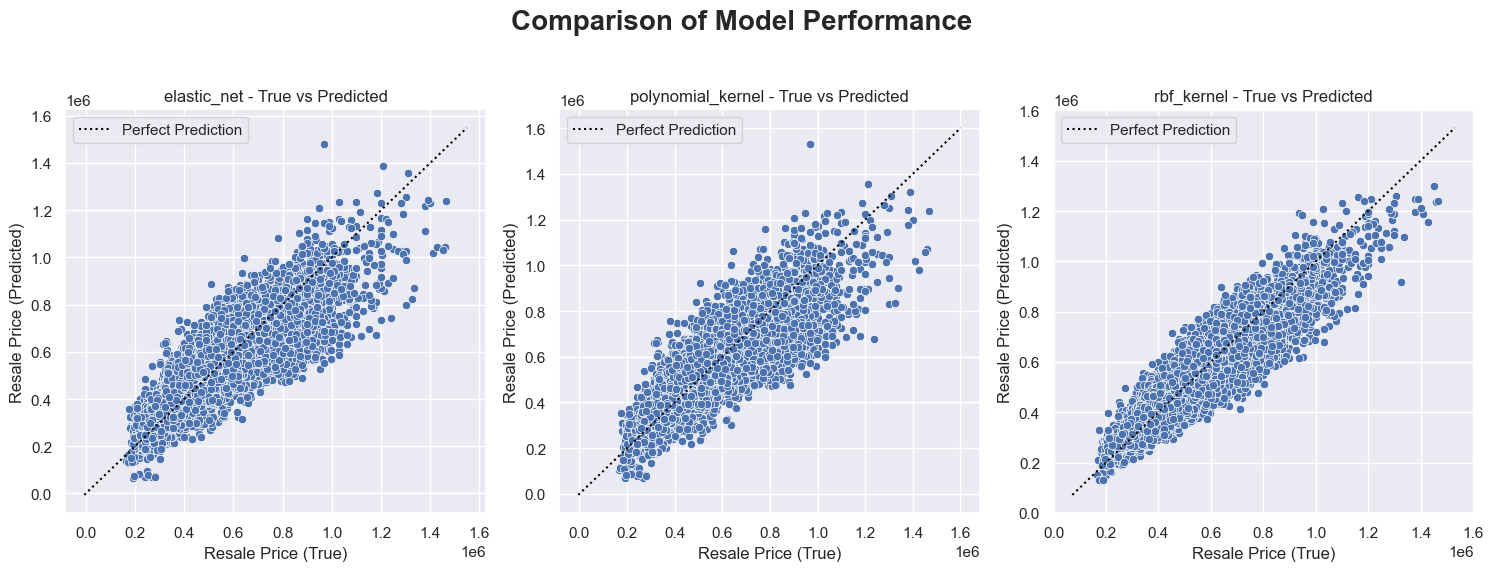

In [28]:
train_models(X, pca_flag=True)

##### From the results, it seems like PCA is not helping much in terms of increasing the mean R² score, but has tremendously improved the compute time. The PCA may not have improved the R² score perhaps due to important features being removed or diluted after the PCA. Hence we can see that PCA does not always work in all cases, but in scenarios where compute time is important or when the data is more linear, PCA could be a useful tool. #####

#### K - Means Clutering - Unsupervised Learning Method 2 ####

Here, a feature engineering step is used to attempt to improve the Mean R² score. Could a clustering algorithm help find important features that improve the metric? K - Means was chosen here to discover hidden relationships that we may have not been presented earlier.

K-means is an unsupervised learning algorithm that partitions a dataset into $( k )$ clusters, where each data point belongs to the cluster with the nearest mean, acting as a prototype of the cluster. The goal is to minimize the total variance within each cluster.

Given a dataset $ X = \{x_1, x_2, \dots, x_n\} $ with $n $ points, where each $ x_i \in \mathbb{R}^d $, the K-means algorithm aims to find $ k $ cluster centroids $ \{ \mu_1, \mu_2, \dots, \mu_k \} $ that minimize the following objective function:

$$
J = \sum_{i=1}^{k} \sum_{x \in C_i} \| x - \mu_i \|^2
$$

where:
- $ J $ is the total within-cluster sum of squares, which measures the variance within each cluster,
- $ C_i $ represents the set of points in the $ i $-th cluster,
- $ \mu_i $ is the centroid of the $ i $-th cluster, calculated as the mean of the points in $ C_i $,
- $ \| x - \mu_i \|^2 $ is the squared Euclidean distance between a point $ x $ and the cluster centroid $ \mu_i $.

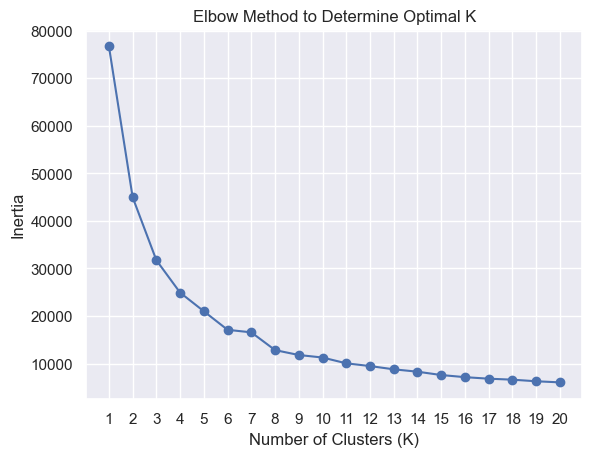

In [29]:
# Preprocess the necessary columns
features = ['resale_price', 
            'floor_area_sqm', 
            'flat_type_encoded',
            'age']  # Numerical features
X = data[features]  # Select only the necessary features for clustering

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use Elbow Method to find optimal K
inertia = []
K_range = range(1, 21)  # Try different K values
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow graph
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method to Determine Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()


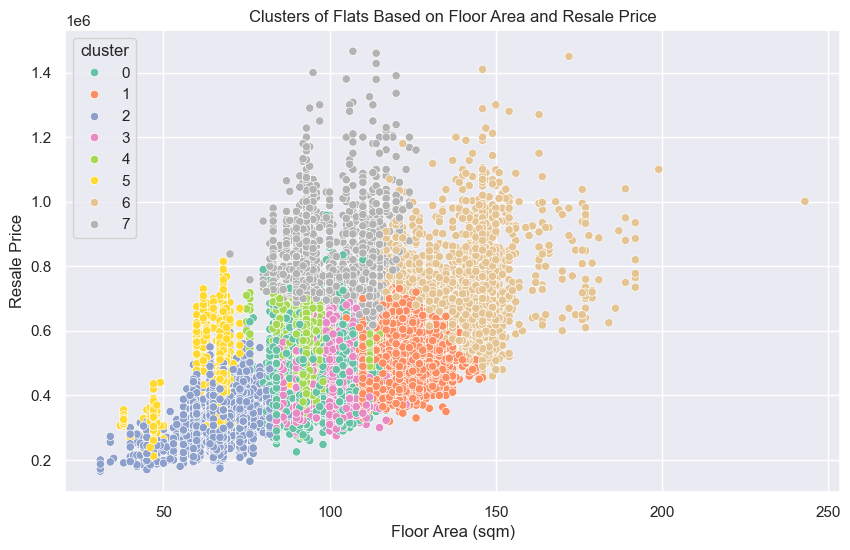

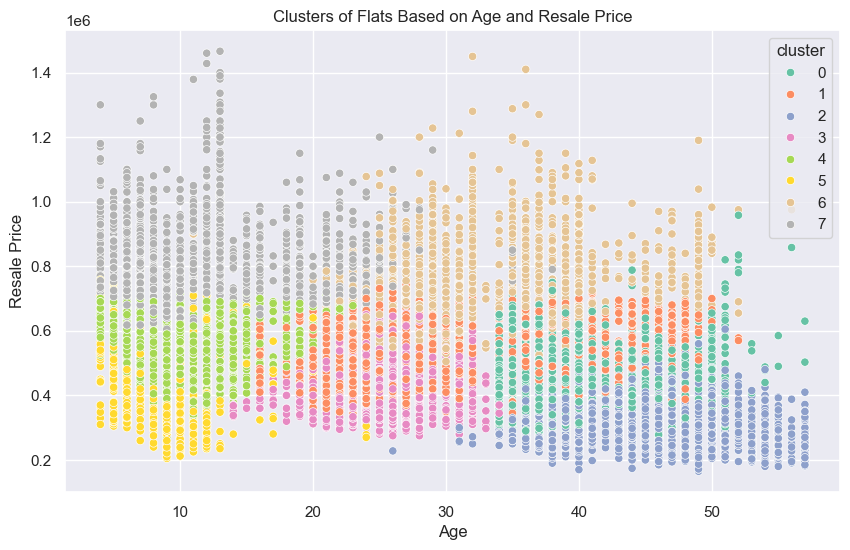

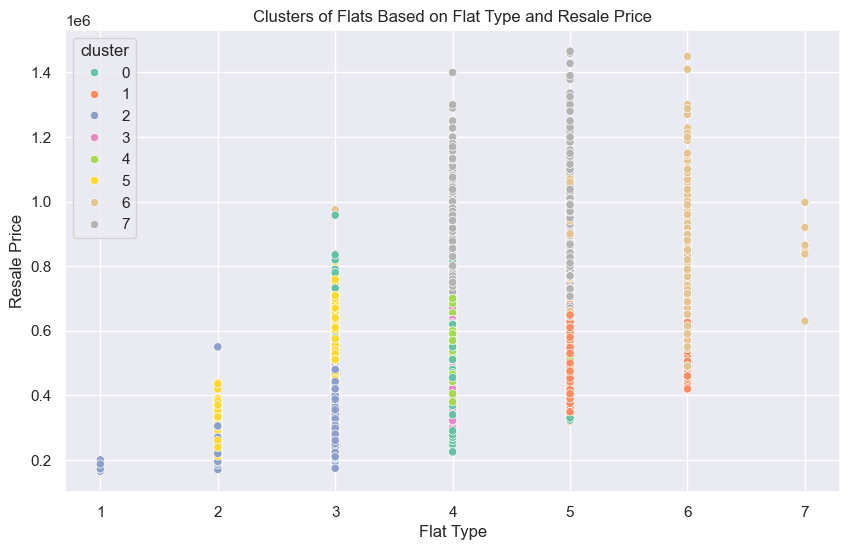

In [30]:
# After choosing K (e.g., K = 4), apply KMeans
optimal_k = 8  # Chosen based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters (for example, on price vs floor area)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['floor_area_sqm'], y=data['resale_price'], hue=data['cluster'], palette='Set2')
plt.title('Clusters of Flats Based on Floor Area and Resale Price')
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Resale Price')
plt.show()

# Visualize the clusters 
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['age'], y=data['resale_price'], hue=data['cluster'], palette='Set2')
plt.title('Clusters of Flats Based on Age and Resale Price')
plt.xlabel('Age')
plt.ylabel('Resale Price')
plt.show()

# Visualize the clusters 
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['flat_type_encoded'], y=data['resale_price'], hue=data['cluster'], palette='Set2')
plt.title('Clusters of Flats Based on Flat Type and Resale Price')
plt.xlabel('Flat Type')
plt.ylabel('Resale Price')
plt.show()

#### With the new clusters generated, let's include it into our analysis to see if it improves the metric ####

In [31]:
# One-hot encode the 'town' column and join it back to the original DataFrame
data = pd.concat([data, pd.get_dummies(data['cluster'], prefix='cluster')], axis=1)
data

,floor_area_sqm,lease_commence_date,resale_price,extracted_month,flat_type_encoded,storey_range_01 TO 03,storey_range_04 TO 06,storey_range_07 TO 09,storey_range_10 TO 12,storey_range_13 TO 15,...,age,cluster,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
81150,67.0,1983,293000.0,10,3,False,True,False,False,False,...,41,2,False,False,True,False,False,False,False,False
73970,72.0,2013,340000.0,7,3,False,False,False,False,False,...,11,5,False,False,False,False,False,True,False,False
25715,85.0,2004,362000.0,4,4,False,False,False,True,False,...,20,3,False,False,False,True,False,False,False,False
84529,123.0,1999,460000.0,11,5,False,True,False,False,False,...,25,1,False,True,False,False,False,False,False,False
73119,60.0,1986,215000.0,7,3,True,False,False,False,False,...,38,2,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85728,93.0,2016,405000.0,12,4,False,True,False,False,False,...,8,4,False,False,False,False,True,False,False,False
2908,84.0,1986,340000.0,3,4,False,True,False,False,False,...,38,0,True,False,False,False,False,False,False,False
175851,84.0,1988,455000.0,3,4,False,False,False,True,False,...,36,0,True,False,False,False,False,False,False,False
37226,120.0,1999,530000.0,10,5,False,False,False,False,True,...,25,1,False,True,False,False,False,False,False,False


In [32]:
# Features and target variable
X = data.drop(columns=['resale_price'])
y = data['resale_price']

Model: elastic_net (Grid Search)
Best Parameters: {'alpha': 0.1, 'l1_ratio': 0.1}
Cross-validated R² scores: [0.82085016 0.83121502 0.82690772]
Mean R² score (cross-val): 0.8263
Standard deviation (cross-val): 0.0043


Model: polynomial_kernel (Regular CV)
Cross-validated R² scores: [0.82494695 0.83369335 0.82941914]
Mean R² score (cross-val): 0.8294
Standard deviation (cross-val): 0.0036


Model: rbf_kernel (Grid Search)
Best Parameters: {'alpha': 0.1, 'gamma': 0.01}
Cross-validated R² scores: [0.77491961 0.79937232 0.80373415]
Mean R² score (cross-val): 0.7927
Standard deviation (cross-val): 0.0127




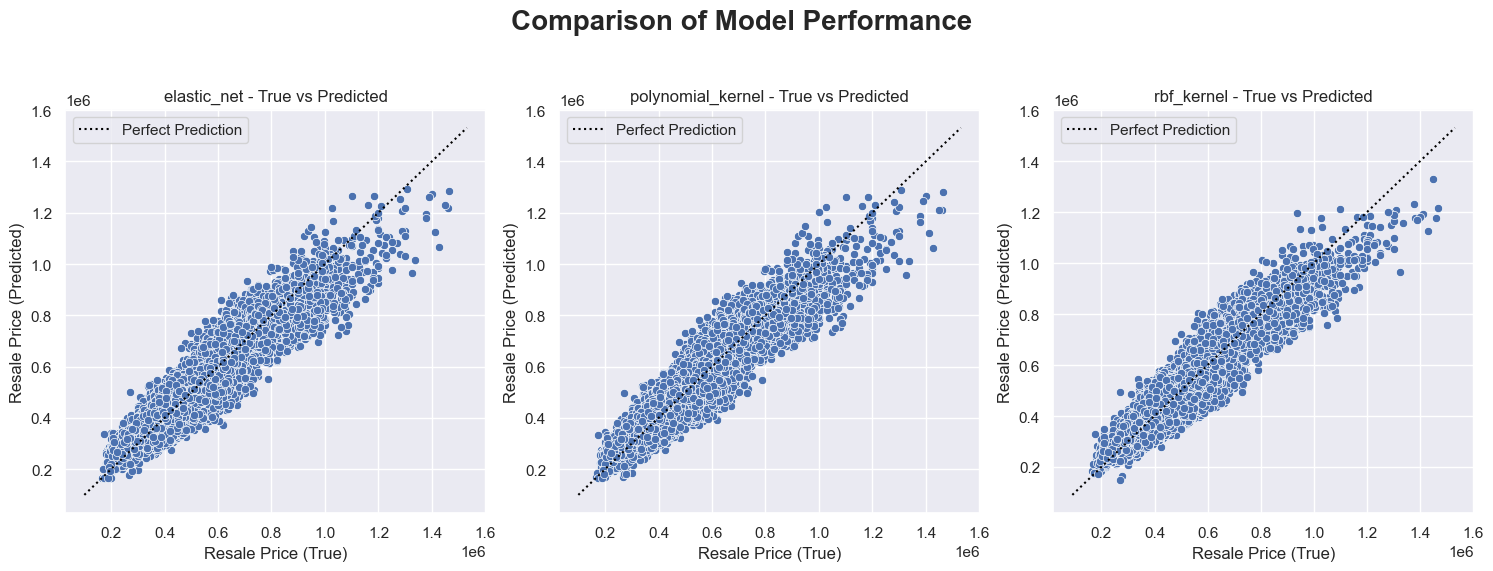

In [33]:
train_models(X,pca_flag=False)

With the additional features from K-Means, all the models perform better on average.

#### Try with PCA + K-means Clustering ####

Model: elastic_net (Grid Search)
Best Parameters: {'alpha': 0.1, 'l1_ratio': 0.9}
Cross-validated R² scores: [0.79226178 0.78978868 0.79658674]
Mean R² score (cross-val): 0.7929
Standard deviation (cross-val): 0.0028


Model: polynomial_kernel (Regular CV)
Cross-validated R² scores: [0.79021155 0.78885704 0.79660231]
Mean R² score (cross-val): 0.7919
Standard deviation (cross-val): 0.0034


Model: rbf_kernel (Grid Search)
Best Parameters: {'alpha': 0.01, 'gamma': 0.01}
Cross-validated R² scores: [0.80566574 0.81462222 0.81750824]
Mean R² score (cross-val): 0.8126
Standard deviation (cross-val): 0.0050




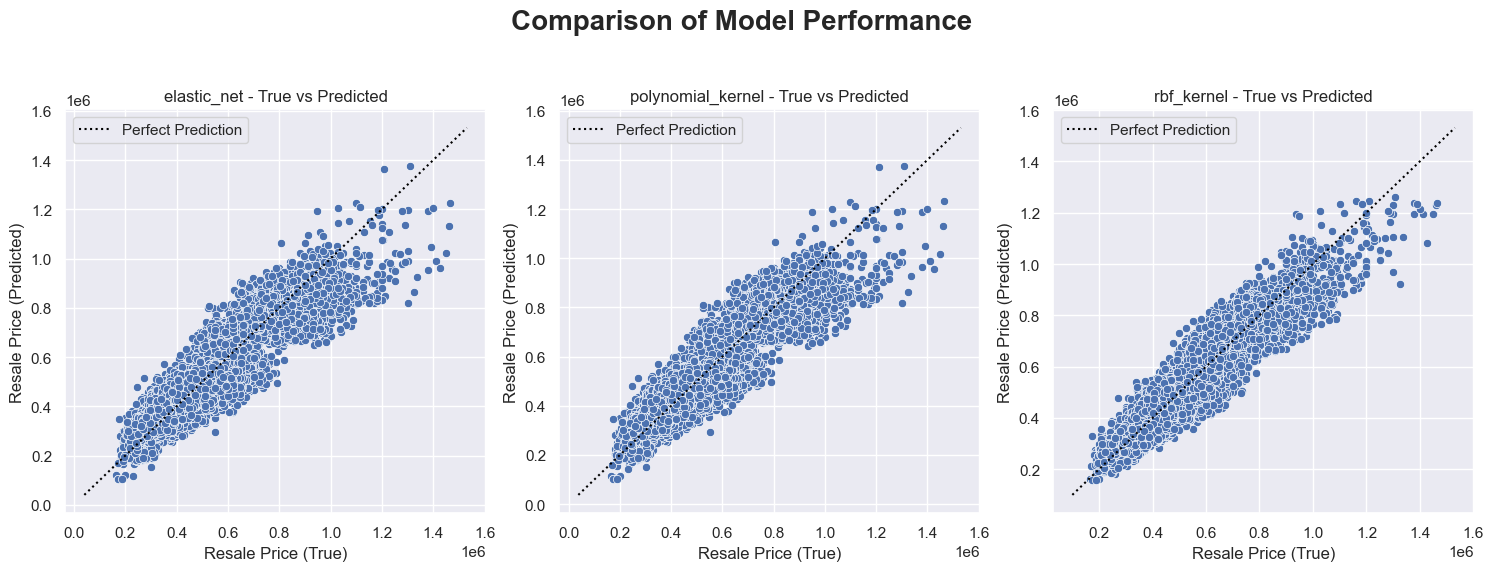

In [34]:
train_models(X,pca_flag=True)

In [35]:
results = {
    "": ["Baseline", "PCA", "K-means", "PCA + K-means"],
    "ElasticNet": [0.7982, 0.6838, 0.8263, 0.7929],
    "Polynomial Kernel": [0.8015, 0.6717, 0.8294, 0.7919],
    "RBF Kernel": [0.7671, 0.7767, 0.7927, 0.8126]
}

# Create the DataFrame
results = pd.DataFrame(results)

results

,,ElasticNet,Polynomial Kernel,RBF Kernel
0,Baseline,0.7982,0.8015,0.7671
1,PCA,0.6838,0.6717,0.7767
2,K-means,0.8263,0.8294,0.7927
3,PCA + K-means,0.7929,0.7919,0.8126


Comparing across all methods, the Polynomial Kernel with K-means clustering yielded the best Mean R² results.